In [ ]:
import numpy as np
import pandas as pd
import os.path
import scipy
import seaborn as sns
from scipy.stats import gengamma, laplace, norm
from scipy.stats import kstwo
from scipy.special import kolmogorov
import matplotlib.pyplot as plt
from utilities import *
from plot_utilities import *
%matplotlib inline
import pickle

np.random.seed(42)

In [2]:
# Note that the code below assumes you are in testing-framework. Can check Current Working Directory below:
# Should be testing-framework
os.getcwd()

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\testing-framework'

In [3]:
data_dict = pd.read_pickle('../data/Panoptic Agriculture/Transformed Dataset/Panoptic_Data_Dict_Normalized.pickle')
# obs_x_dict = dict()
# for layer in np.arange(2, 9):
#     obs_x_dict[layer] = create_obs_x(data_dict, layer)
# pd.to_pickle(obs_x_dict, 'panoptic/obs_x_dict.pickle')
obs_x_dict = pd.read_pickle('panoptic/obs_x_dict.pickle')
obs_x_dict

{2: array([-99.93568594, -91.00645124, -88.54430615, ...,  88.80035968,
         91.52850405,  94.44944672]),
 3: array([-76.13432886, -63.02074639, -60.52416619, ...,  65.19608846,
         65.26965934,  69.44498554]),
 4: array([-51.73647153, -48.46756551, -45.83266202, ...,  48.25087164,
         50.33643736,  64.88734264]),
 5: array([-47.95678457, -43.34915759, -36.2290875 , ...,  36.11999915,
         38.35812055,  42.17747737]),
 6: array([-23.87540781, -23.66829959, -23.29668418, ...,  25.41955052,
         31.52717851,  44.79754701]),
 7: array([-19.12997336, -18.52962064, -17.2224645 , ...,  16.63923718,
         17.96650462,  20.30569957]),
 8: array([-18.71256003, -17.84609759, -16.94317757, ...,  15.43083627,
         16.78232461,  20.5891778 ])}

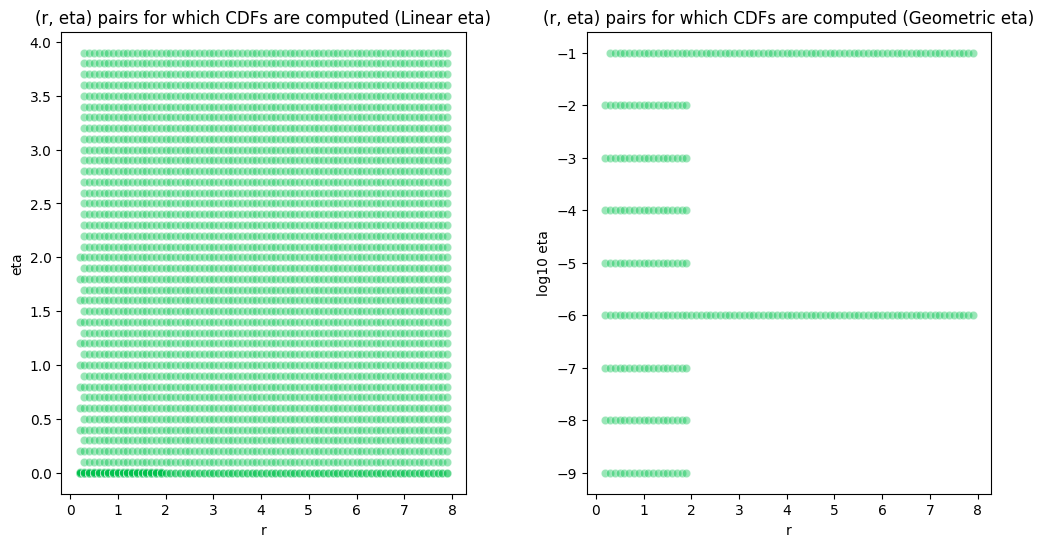

In [36]:
# Large grid search CDFs already computed (r = 0 to 8, eta = 0 to 3.9)
all_cdfs = combine_pickles('scipy_10000') | combine_pickles('mtlb_10000') 
all_cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(all_cdfs.items())})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[1])

create_scatter_plots_log_eta(all_cdfs_df)

Best parameters (0.6, 3.2) with KS-test Statistic 0.0383 and pvalue 0.0001693037457256742, layer 2 with num_samples=3180


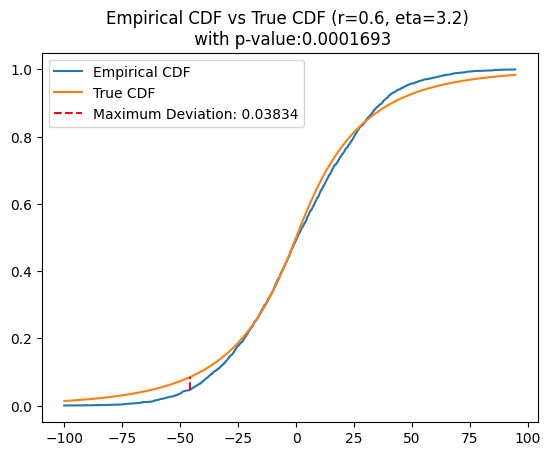

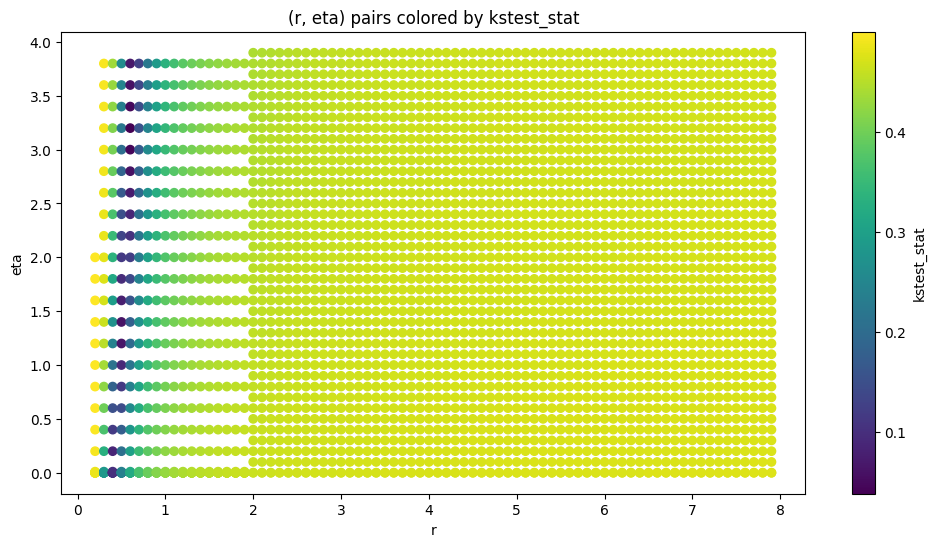

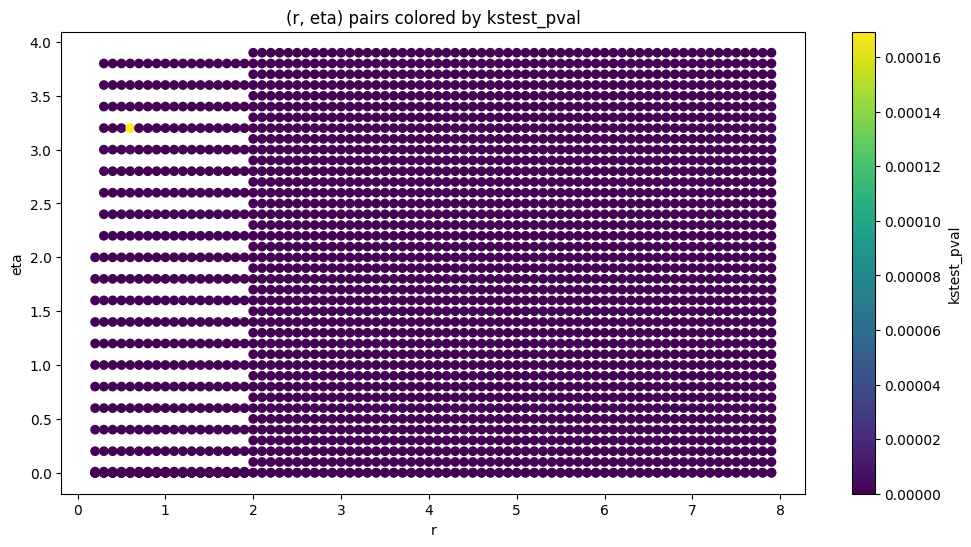

,"(r,eta),cdf",r,eta,cdf,kstest_stat,kstest_pval
0,"((0.2, 0), <scipy.interpolate._cubic.CubicSpli...",0.2,0.000000e+00,<scipy.interpolate._cubic.CubicSpline object a...,0.485706,0.0
1,"((0.2, 1e-09), <scipy.interpolate._cubic.Cubic...",0.2,1.000000e-09,<scipy.interpolate._cubic.CubicSpline object a...,0.485706,0.0
2,"((0.2, 1e-08), <scipy.interpolate._cubic.Cubic...",0.2,1.000000e-08,<scipy.interpolate._cubic.CubicSpline object a...,0.485706,0.0
3,"((0.2, 1e-07), <scipy.interpolate._cubic.Cubic...",0.2,1.000000e-07,<scipy.interpolate._cubic.CubicSpline object a...,0.485706,0.0
4,"((0.2, 1e-06), <scipy.interpolate._cubic.Cubic...",0.2,1.000000e-06,<scipy.interpolate._cubic.CubicSpline object a...,0.485706,0.0


In [16]:
# Experimental cell demoing all the plots
layer = 2
obs_x = obs_x_dict[layer]
all_ksstats, best_param, min_stat = gridsearch(obs_x, all_cdfs)
df = all_cdfs_df.copy()
total_samples = obs_x.size
df['kstest_stat'] = all_ksstats
df['kstest_pval'] = kstwo(n=total_samples).sf(all_ksstats)
print(f"Best parameters {(best_param)} with KS-test Statistic {np.round(min_stat, 4)} and pvalue {kstwo(n=total_samples).sf(min_stat)}, layer {layer} with num_samples={total_samples}")
distance, location = visualize_cdfs(obs_x, best_param[0], best_param[1], 10000, all_cdfs)
create_scatter_plot(df, 'kstest_stat')
create_scatter_plot(df, 'kstest_pval')

ValueError: cannot reshape array of size 2112 into shape (72,32)

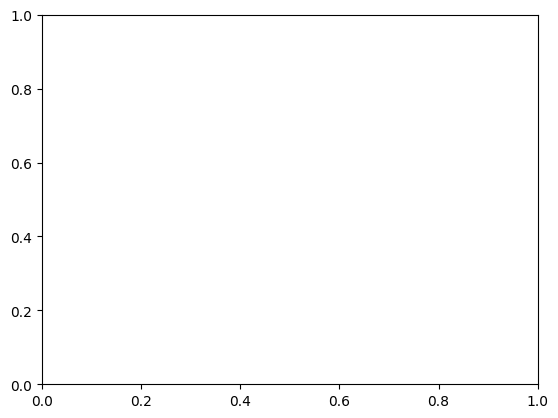

In [34]:
df0 = df[(df['r'] > 0.7) & (df['eta'] >= 0.8)]
indices = df0.index
x = np.array(df0['r'].loc[indices])
y = np.array(df0['eta'].loc[indices])
z = np.array(df0['kstest_stat'].loc[indices]) 
X, Y = np.meshgrid(df0['r'].unique(), df0['eta'].unique())

dims_r = df0['r'].unique().size
dims_eta = df0['eta'].unique().size
fig, ax = plt.subplots()
CS = ax.contour(x.reshape(dims_r, dims_eta), y.reshape(dims_r, dims_eta), z.reshape(dims_r, dims_eta), np.append(np.arange(0.04, 0.3, 0.02), 0.3), cmap =  'viridis')
ax.clabel(CS, CS.levels, inline=True, fontsize=10)
create_contour_plot(df0,'kstest_stat')

In [28]:
# Given that pvalue = 0.05 and I have _ samples, what should the kstest statistic be?
cutoffs_df = pd.DataFrame(columns = ['layer', 'num_samples', 'kstest_stat_0.05_cutoff', 'kstest_stat_0.1_cutoff'])
for i, layer in enumerate(np.arange(2, 9)):
    num_points = obs_x_dict[layer].size
    cutoffs_df.loc[i, :] = (layer, num_points, kstwo(n=num_points).isf(0.05), kstwo(n=num_points).isf(0.1))
    
cutoffs_df

,layer,num_samples,kstest_stat_0.05_cutoff,kstest_stat_0.1_cutoff
0,2,3180,0.02403,0.02165
1,3,12720,0.012029,0.010838
2,4,50880,0.006018,0.005422
3,5,203520,0.00301,0.002712
4,6,814080,0.001505,0.001356
5,7,3256320,0.000753,0.000678
6,8,13025280,0.000376,0.000339


In [10]:
best_params_df = pd.read_csv('panoptic/CSVs/best_params_df_fine_grid.csv')
pd.read_csv('panoptic/CSVs/best_params_df_fine_grid.csv')

,layer,num_samples,"(r, eta)",kstest_stat,kstest_pval
0,2,3180,"(0.602, 3.2)",0.036033,5.051908e-04
1,3,12720,"(0.7048, 3.63)",0.018350,3.762093e-04
2,4,50880,"(0.79, 0.24)",0.218044,0.000000e+00
3,5,203520,"(0.904, 1.62)",0.003040,4.637489e-02
4,6,814080,"(1.028, 0.33)",0.003651,7.517232e-10
5,7,3256320,"(4.629, 0)",0.024877,0.000000e+00
6,8,13025280,"(5.701, 0)",0.171259,0.000000e+00


In [14]:
def find_n_fixed_pval_stat(ksstat, n, pval = 0.05):
    curr_pval = kstwo(n).sf(ksstat)
    while round_to_sigfigs(curr_pval, 5) == 0.05:
        if curr_pval > 0.05:
            n = int(n*1.5)
        elif curr_pval < 0.05: 
            n = int(n/2)
    return n
find_n_fixed_pval_stat(0.036, 3180)

In [12]:
kstest_custom(obs_x_dict[5], combine_pickles('layer5_10000')[(0.904, 1.62)])

(0.003040161847041367, 0.046374891457026224)

In [22]:
%%time
# Creates validation dataframes 
# For now, it caps out at 6. For layer 7 and up it just defaults to 2.9, 0

# for layer in range(6, 8):
#     obs_x = create_obs_x(data_dict, layer)
#     df = make_layer_df(obs_x, all_cdfs_df)
#     total_samples = obs_x.size
#     all_num_samples = np.sort(np.append(5*10**np.arange(3.0, np.floor(np.log10(total_samples))), 10**np.arange(3.0, np.ceil(np.log10(total_samples)))))
#     print(list(all_num_samples))
#     np.random.seed(42)
#     x = obs_x[np.random.permutation(total_samples)]
#     val_df = pd.concat([val_df_fixed_num(x, n, all_cdfs_df) for n in all_num_samples])
#     val_df.to_csv(f'panoptic/CSVs/val_df{layer}_{cdfs_name}.csv')
#     val_df.value_counts(['r', 'eta'])

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
val_df = pd.read_csv(f'panoptic/CSVs/val_df{4}.csv', index_col='Unnamed: 0')
print(val_df.value_counts(['r', 'eta'])[:10])

r    eta
0.8  3.0    141
     3.2    107
     2.8     76
     3.4     65
0.7  1.8     36
0.8  3.6     33
     3.8     29
0.7  1.6     26
     2.0     23
0.8  2.6     23
Name: count, dtype: int64


FileNotFoundError: [Errno 2] No such file or directory: 'panoptic/CSVs/val_df6_cdfs_lite.csv'

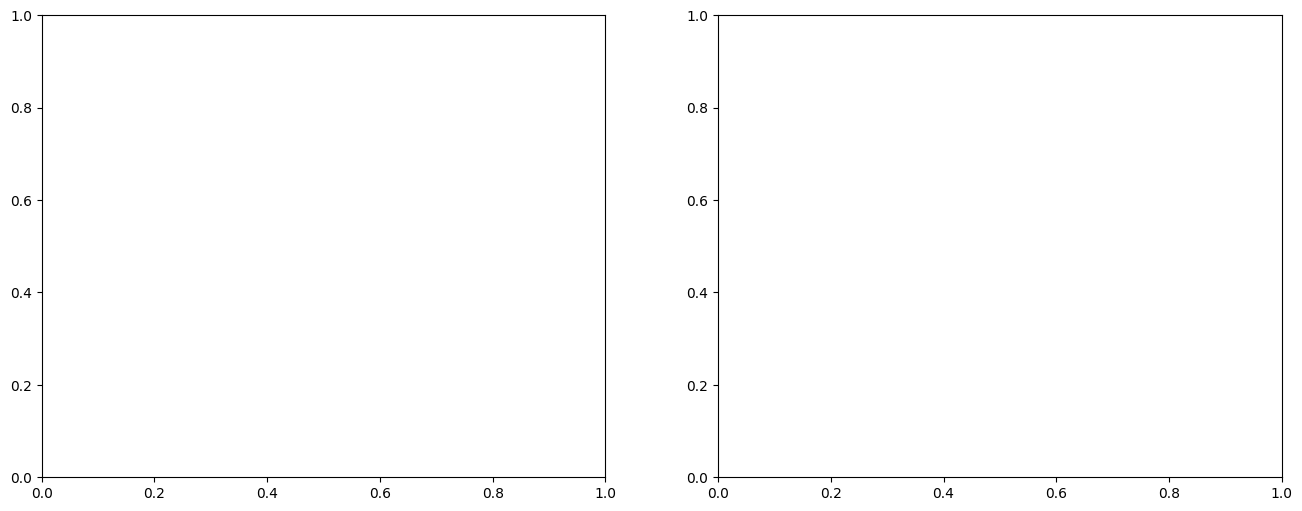

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Create a figure with two subplots

for layer in np.arange(layer, layer+1):
    #obs_x = obs_x_dict[layer]
    #df = df_dict[layer]
    total_samples = obs_x.size
    x = obs_x[np.random.permutation(total_samples)]
    val_df = pd.read_csv(f'panoptic/CSVs/val_df{layer}_{cdfs_name}.csv', index_col='Unnamed: 0')

    # Scatter plot
    sns.scatterplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis=1), x='r', y='eta', palette='bright', hue='num_samples', alpha=0.4, ax=ax1)
    r, eta = best_params_df.loc[layer]['r'], best_params_df.loc[layer]['eta']
    ax1.scatter(x=r, y=eta, marker="*", label='all_data', s=60, color='xkcd:shamrock green', alpha=0.7)
    ax1.set_title(f'KS-Test Statistic minimizing parameters for subsets of layer {layer} data')
    print(r, eta)
    ax1.legend()

    # KDE plot
    sns.kdeplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis=1), x='r', y='eta', palette='bright', hue='num_samples', alpha=0.4, ax=ax2)

plt.tight_layout()
plt.show()

0.9 1.6


C:\Users\yashd\AppData\Local\Temp\ipykernel_41308\293657630.py:17: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 0.4)
C:\Users\yashd\AppData\Local\Temp\ipykernel_41308\293657630.py:17: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 0.4)
C:\Users\yashd\AppData\Local\Temp\ipykernel_41308\293657630.py:17: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 

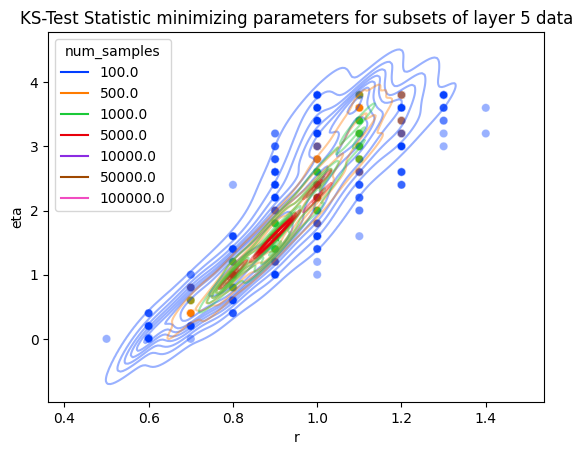

In [62]:
np.random.seed(42)

# TODO: Put plots side by side
for layer in np.arange(layer, layer+1):
    obs_x = obs_x_dict[layer]
    df = df_dict[layer]
    total_samples = obs_x.size
    x = obs_x[np.random.permutation(total_samples)]
    val_df = pd.read_csv(f'panoptic/CSVs/val_df{layer}.csv', index_col='Unnamed: 0')
    sns.scatterplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 0.4)
    r, eta, = best_params_df.loc[layer]['r'], best_params_df.loc[layer]['eta']
    plt.scatter(x = r, y = eta, marker="*", label = 'all_data', s = 60, color = 'xkcd:shamrock green', alpha = 0.7)
    plt.title(f'KS-Test Statistic minimizing parameters for subsets of layer {layer} data')
    print(r, eta)
    plt.legend()
    
    sns.kdeplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 0.4)
    

Text(0.5, 1.0, 'Validation')

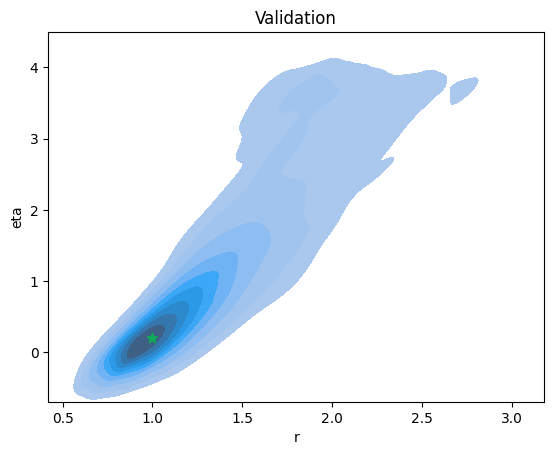

In [47]:
layer = 6
val_df = pd.read_csv(f'panoptic/CSVs/val_df{layer}.csv', index_col='Unnamed: 0')
mask = val_df['num_samples'] == 100
sns.kdeplot(val_df.drop(['kstest_pval'], axis = 1)[mask], x = 'r', y = 'eta', fill=True)
r, eta, = best_params_df.loc[layer]['r'], best_params_df.loc[layer]['eta']
plt.scatter(x = r, y = eta, marker="*", label = 'all_data', s = 60, color = 'xkcd:shamrock green', alpha = 0.7)
plt.title('Validation')